### Part 3: Regression for joint angles

In this phase of the project, we will focus exclusively on Subject 1 from the NinaPro Dataset 8. Unlike classification, the objective here is regression, aiming 
to predict joint angles based on input EMG data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

### Visualization and Preprocessing

In [2]:
base_zip_path = '../data/'
data = loadmat(base_zip_path + 'S1_E1_A1.mat')
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [3]:
emg_data = data["emg"]
n_electrodes = emg_data.shape[1]
print("EMG data dimension: {}".format(emg_data.shape))
print("EMG data type: {}".format(type(emg_data)))
n_joints = 5
glove_data_index = data["glove"][:,[2,5,7,10,13]]  #NOT sure about -1
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>
Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


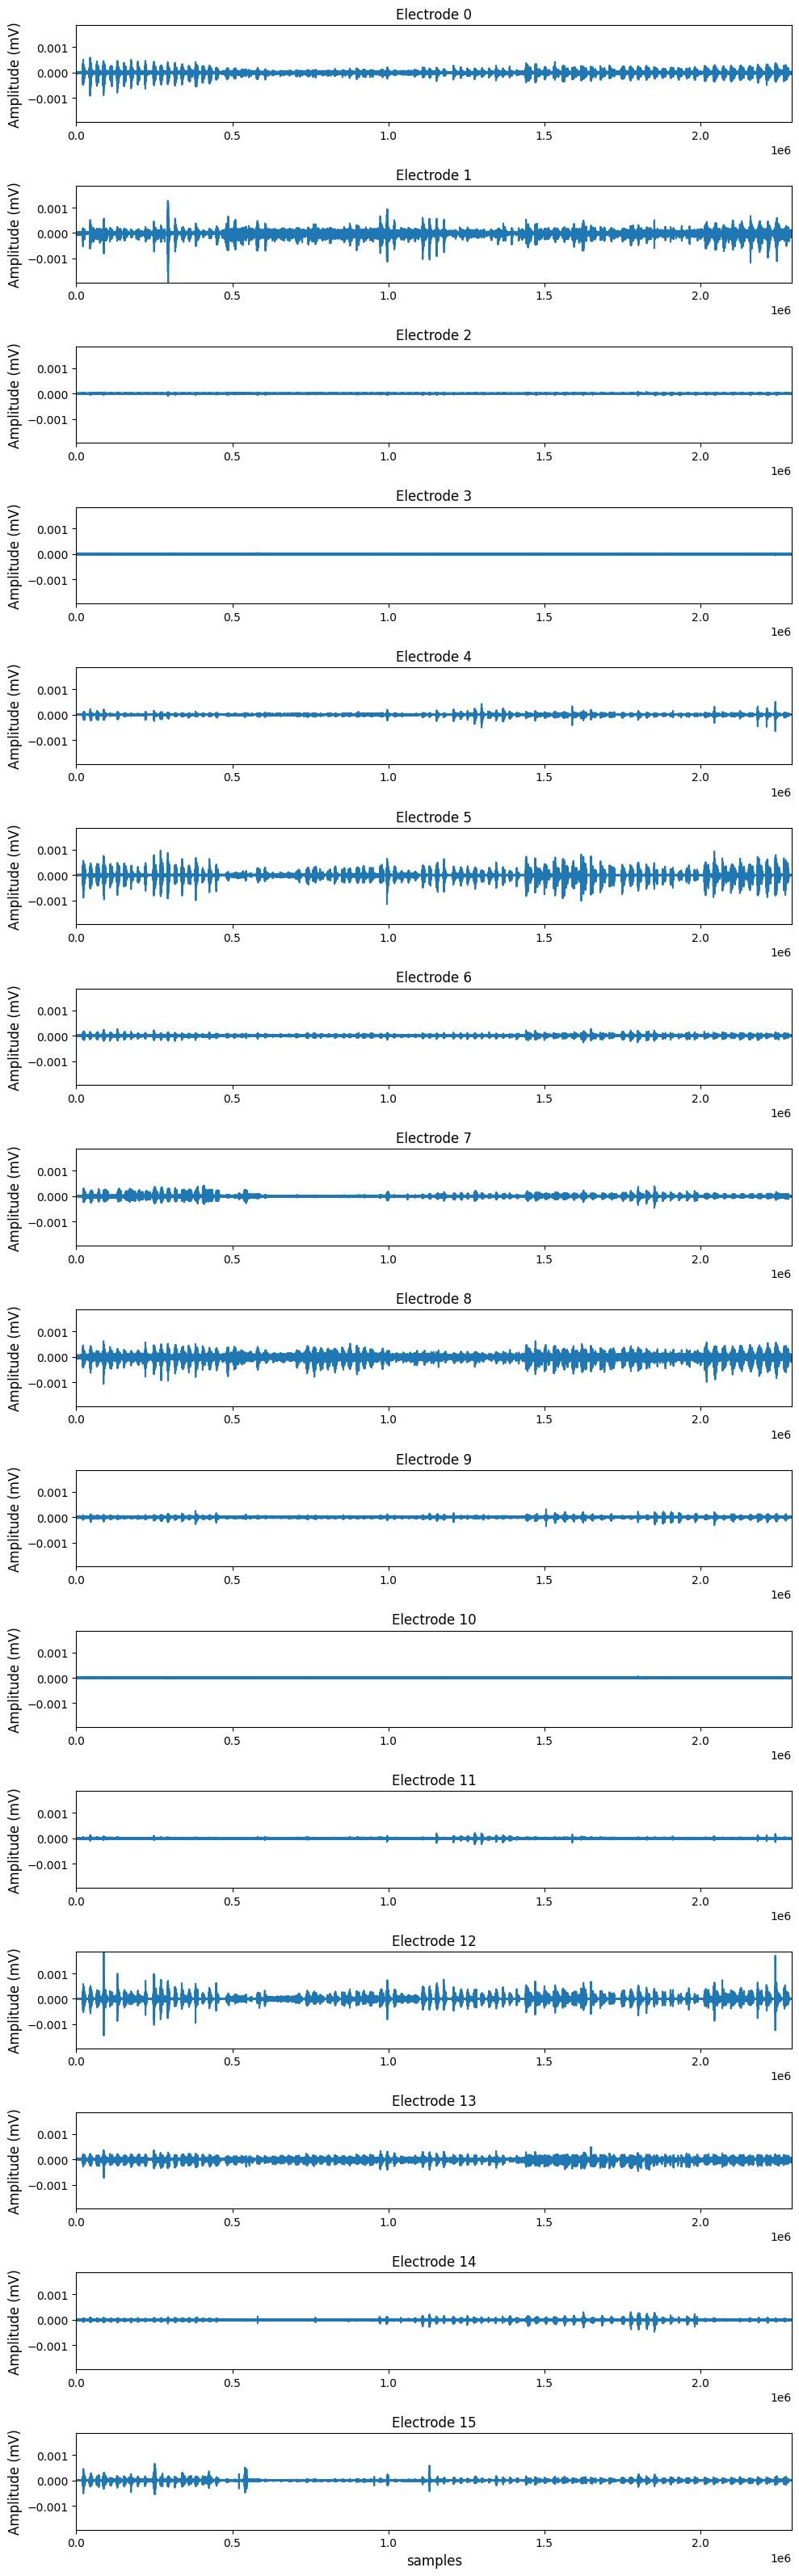

In [4]:
fig, axs = plt.subplots(n_electrodes, 1, figsize=(10, n_electrodes * 2))
plt.subplots_adjust(hspace=0.5)
y_upper_limit = np.max(emg_data)
y_lower_limit = np.min(emg_data)
for i in range(n_electrodes):
    axs[i].plot(emg_data[:, i])
    axs[i].set_title("Electrode {}".format(i))
    axs[i].set_xlim(0, emg_data.shape[0])
    axs[i].set_ylim(y_lower_limit, y_upper_limit)
    if i == n_electrodes - 1:
        axs[i].set_xlabel("samples", fontsize=12)
    axs[i].set_ylabel("Amplitude (mV)", fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
electrode_std = np.std(emg_data, axis=0)
electrode_mean = np.mean(emg_data, axis=0)
print("Electrode std: {}".format(electrode_std))
print("Electrode mean: {}".format(electrode_mean))
emg_data = (emg_data - electrode_mean) / electrode_std # z-score normalization

Electrode std: [3.3488803e-05 4.6500762e-05 5.0302629e-06 4.3265318e-06 1.2873382e-05
 4.0677249e-05 1.2841571e-05 1.5643713e-05 5.2814736e-05 1.2895861e-05
 5.5280793e-06 7.2447856e-06 3.8543341e-05 2.6413196e-05 1.1397861e-05
 1.5296004e-05]
Electrode mean: [ 8.89174290e-11  5.90248336e-11  5.35277933e-11  7.31331731e-11
 -2.13157530e-11  1.96876608e-12  6.98533453e-11 -2.79635759e-11
  5.73644410e-10  5.32423550e-11  5.86508481e-11 -1.05476766e-10
 -3.21209240e-11  6.64641328e-11 -8.40253145e-11 -7.18306525e-11]


We observe that some electrodes exhibit lower amplitude signals; however, the standard deviations appear to be of the same order of magnitude, suggesting that all sensors were functioning properly. Now, let’s proceed to clean these signals.

First, let’s examine the frequency domain!

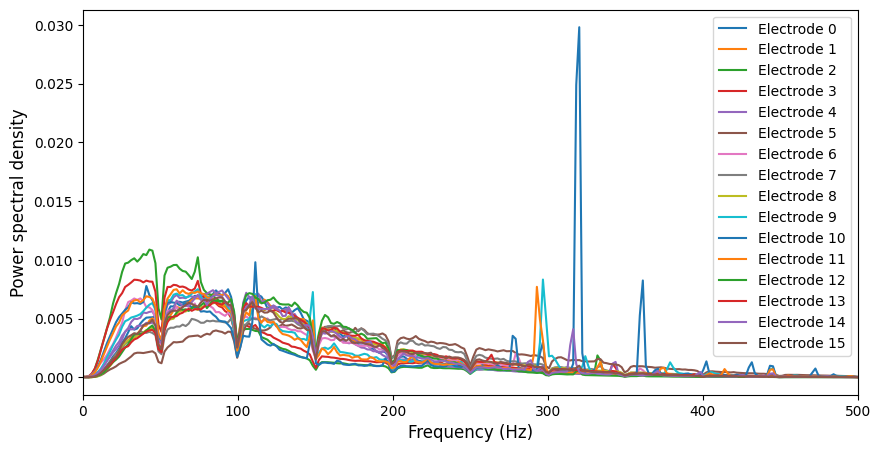

In [6]:
fs = 2000
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_electrodes):
    f, Pxx = welch(emg_data[:, i], fs, nperseg=1024)
    ax.plot(f, Pxx, label="Electrode {}".format(i))
ax.set_xlim(0, 500)
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Power spectral density", fontsize=12)
ax.legend()
plt.show()


For certain electrodes, we observe a bump at higher frequencies, which may be attributed to the electrode signal itself rather than noise

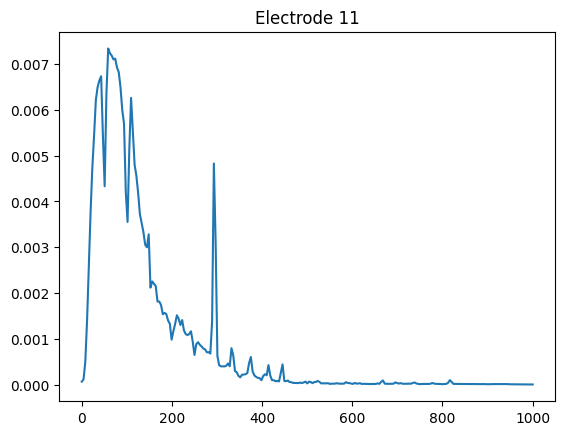

In [7]:
# plot welch for just electrode 11
f, Pxx = welch(emg_data[:, 11], fs, nperseg=512)
plt.plot(f, Pxx)
plt.title("Electrode 11")
plt.show()


We can remove signals with frequencies lower than 5Hz and higher than 500Hz as they are outside the band of EMG signals.

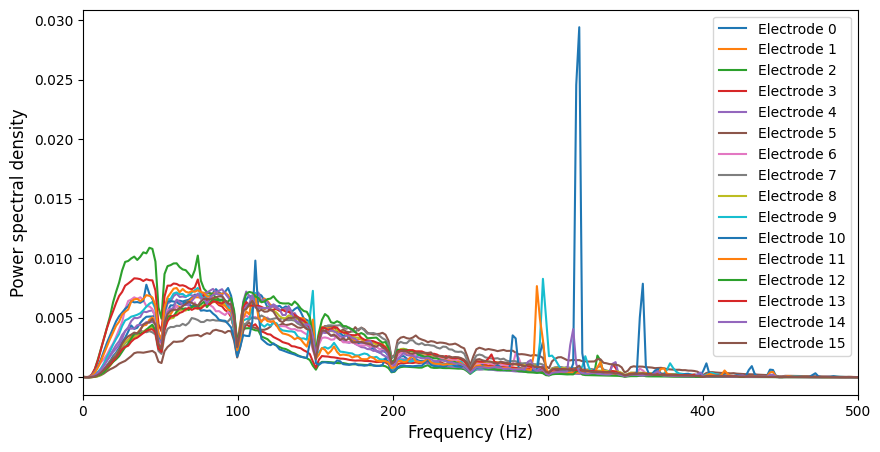

In [8]:
bandpass_cutoff_frequencies_Hz = (5, 500) 
sos = butter(4, bandpass_cutoff_frequencies_Hz, btype="band", fs=fs, output="sos")
emg_data_filtered = sosfiltfilt(sos, emg_data, axis=0)
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_electrodes):
    f, Pxx = welch(emg_data_filtered[:, i], fs, nperseg=1024)
    ax.plot(f, Pxx, label="Electrode {}".format(i))
ax.set_xlim(0, 500)
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Power spectral density", fontsize=12)
ax.legend()
plt.show()



Not a lot has changed! let's remove powergrid noise (harmonic frequencies of 50hz)

Filtering out power grid noise at 50 Hz
Filtering out power grid noise at 100 Hz
Filtering out power grid noise at 150 Hz
Filtering out power grid noise at 200 Hz


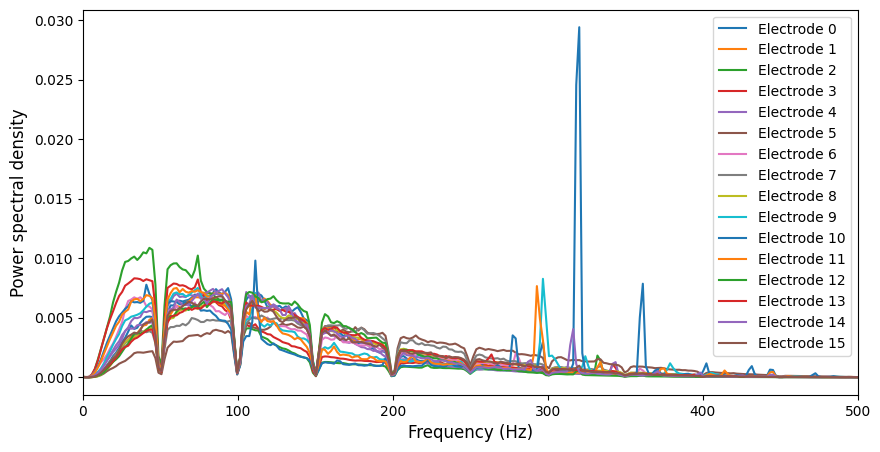

In [9]:
powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,5)] 
for noise_frequency in powergrid_noise_frequencies_Hz:
    print("Filtering out power grid noise at {} Hz".format(noise_frequency))
    bandstop_cutoff_frequencies_Hz = (noise_frequency-2, noise_frequency+2)
    sos = butter(4, bandstop_cutoff_frequencies_Hz, btype="bandstop", fs=fs, output="sos")
    emg_data_filtered = sosfiltfilt(sos, emg_data_filtered, axis=0)
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_electrodes):
    f, Pxx = welch(emg_data_filtered[:, i], fs, nperseg=1024)
    ax.plot(f, Pxx, label="Electrode {}".format(i))
ax.set_xlim(0, 500)
ax.set_xlabel("Frequency (Hz)", fontsize=12)
ax.set_ylabel("Power spectral density", fontsize=12)
ax.legend()
plt.show()


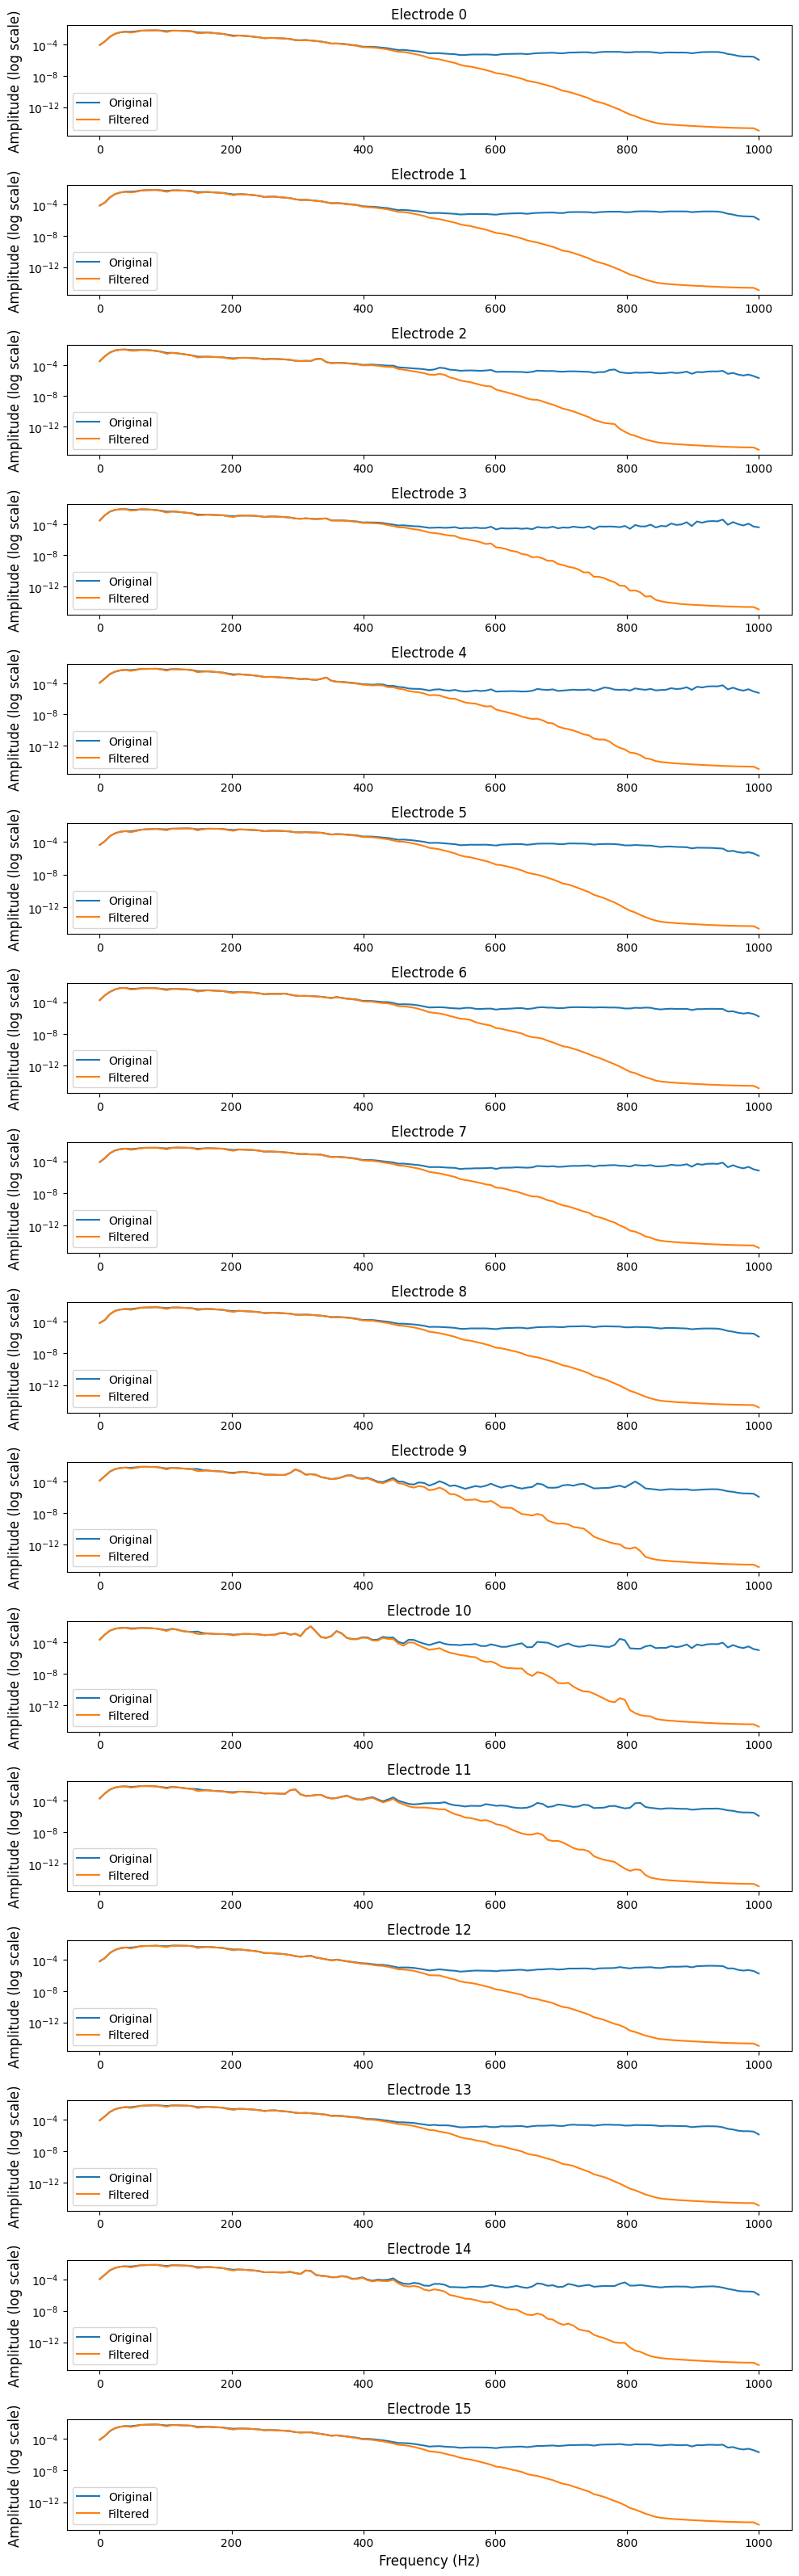

In [10]:
fig, axs = plt.subplots(n_electrodes, 1, figsize=(10, n_electrodes * 2))
plt.subplots_adjust(hspace=0.5)
for i in range(n_electrodes):
    f, Pxx = welch(emg_data[:, i], fs, nperseg=256)
    axs[i].plot(f, Pxx, label="Original")
    f, Pxx = welch(emg_data_filtered[:, i], fs, nperseg=256)
    axs[i].plot(f, Pxx, label="Filtered")
    axs[i].set_yscale("log")
    axs[i].set_title("Electrode {}".format(i))
    if i == n_electrodes - 1:
        axs[i].set_xlabel("Frequency (Hz)", fontsize=12)
    axs[i].set_ylabel("Amplitude (log scale)", fontsize=12)
    axs[i].legend()
plt.tight_layout()
plt.show()


Overall in log scale the difference is not huge. Additional preprocessing such as smoothing are then applied

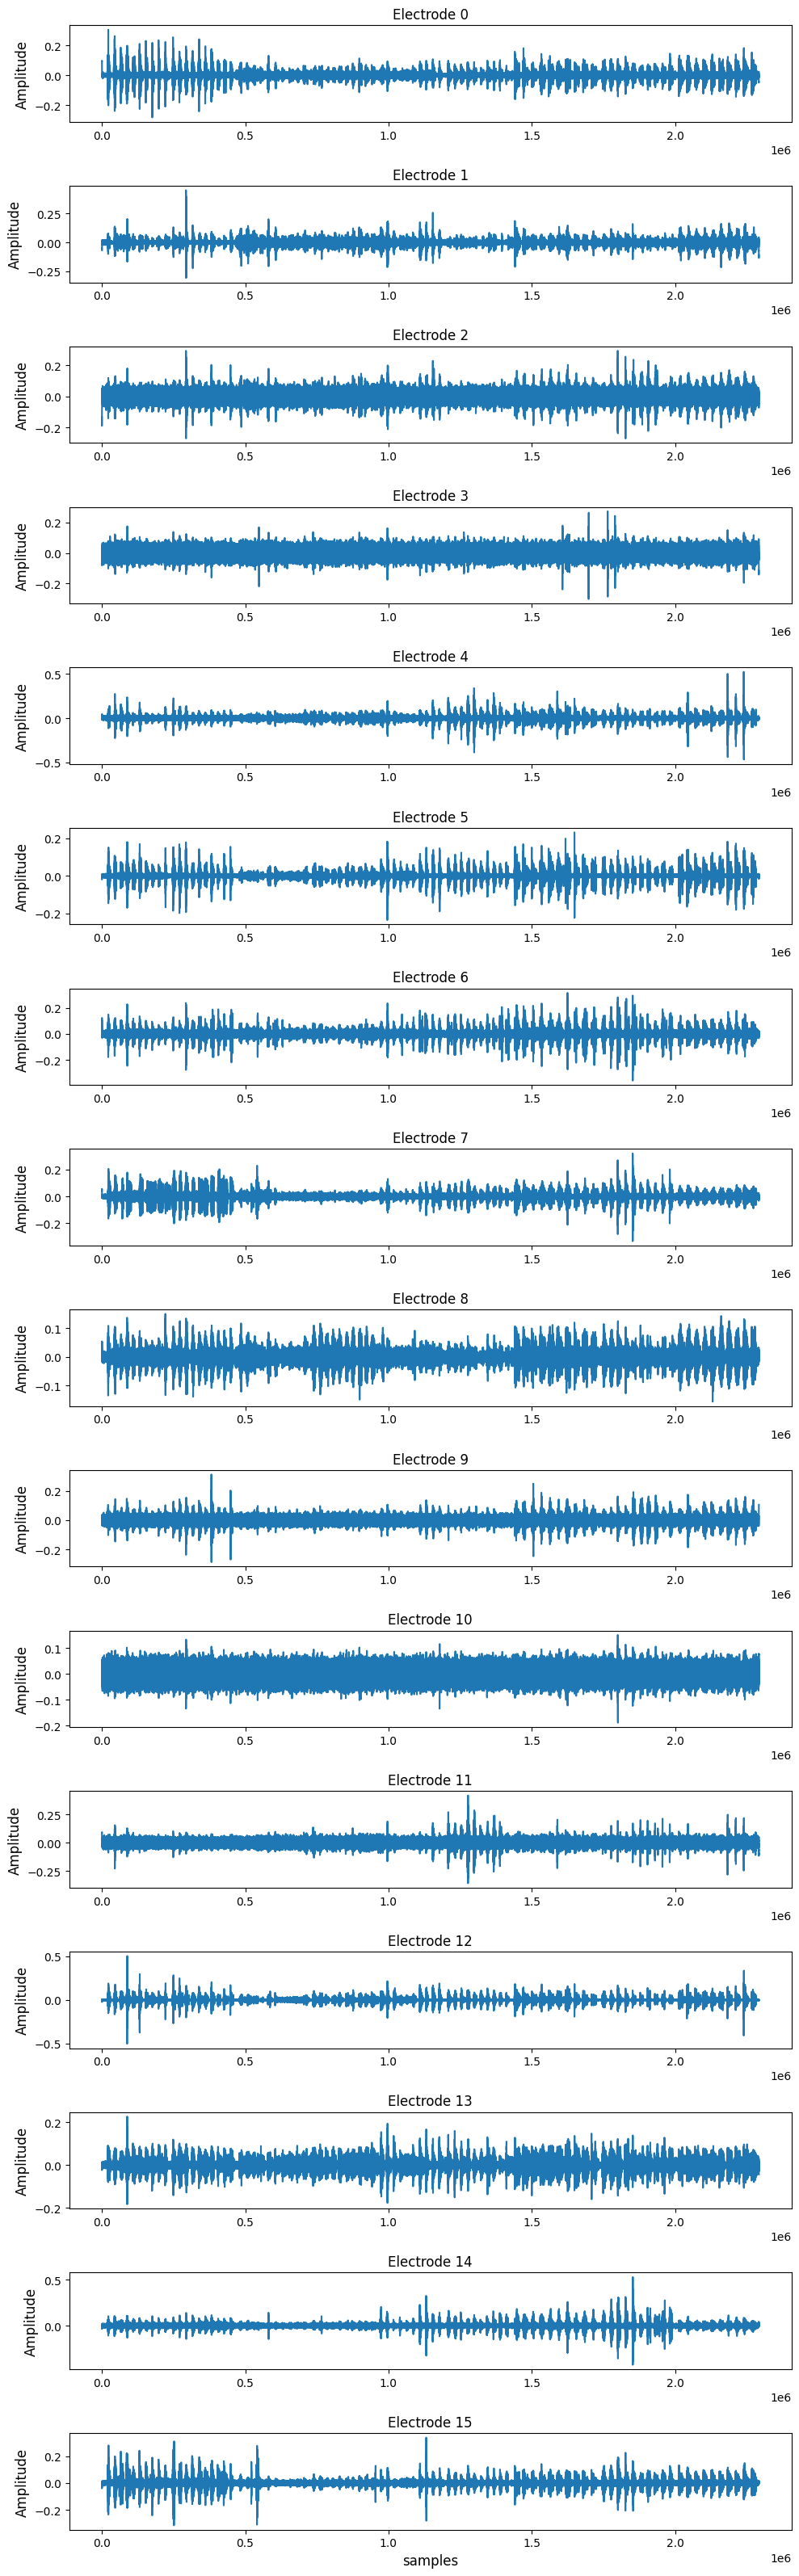

In [11]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data_filtered, mov_mean_weights, axis=0)

#Plotting the envelopes
fig, axs = plt.subplots(n_electrodes, 1, figsize=(10, n_electrodes * 2))
plt.subplots_adjust(hspace=0.5)
for i in range(n_electrodes):
    axs[i].plot(EMG_envelopes[:, i])
    axs[i].set_title("Electrode {}".format(i))
    if i == n_electrodes - 1:
        axs[i].set_xlabel("samples", fontsize=12)
    axs[i].set_ylabel("Amplitude", fontsize=12)
plt.tight_layout()
plt.show()



Now that our signal form the electrode has been properly preprocessed we can quickly have a look at the glove data !

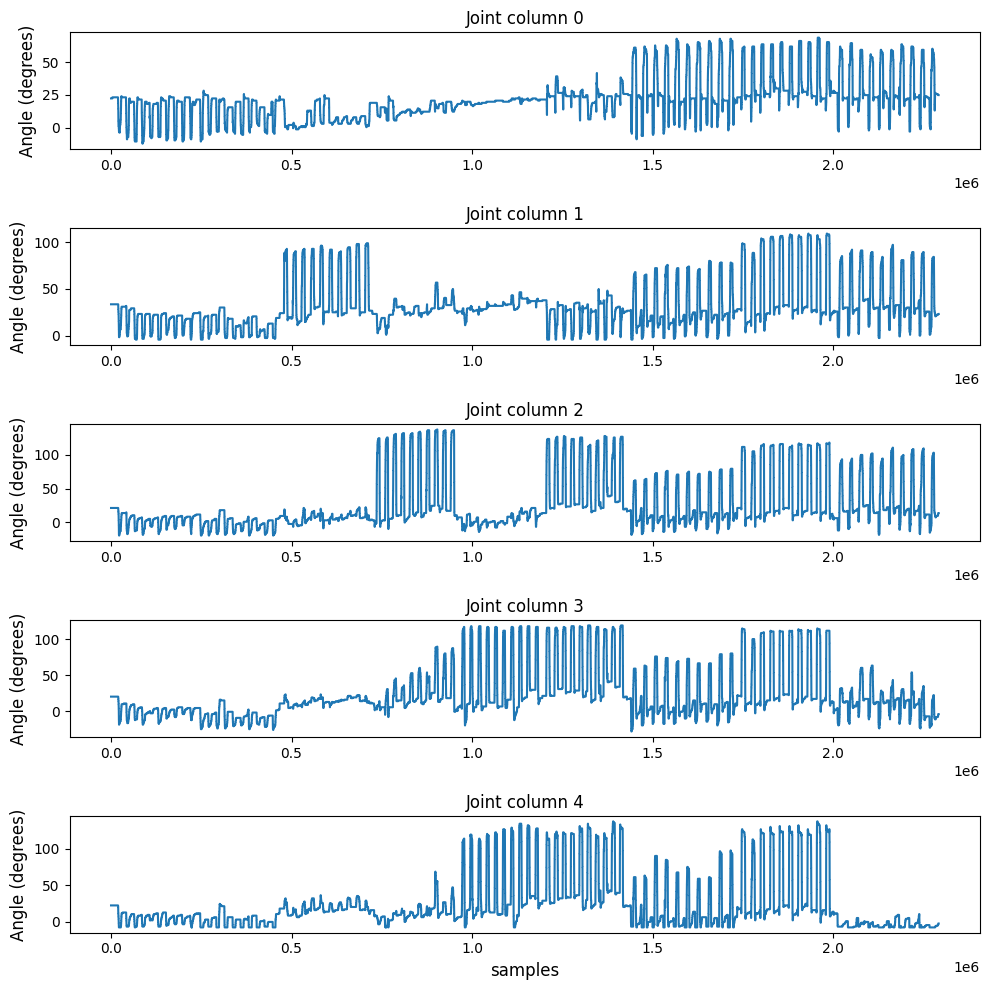

In [12]:
fig, axs = plt.subplots(n_joints, 1, figsize=(10, 10))
for i in range(n_joints):
    axs[i].plot(glove_data_index[:, i])
    axs[i].set_title("Joint column {}".format(i))
    if i == n_joints - 1:
        axs[i].set_xlabel("samples", fontsize=12)
    axs[i].set_ylabel("Angle (degrees)", fontsize=12)
plt.tight_layout()
plt.show()


### Spliting dataset

Time series data must be carefully split to avoid data leakage. Splitting should be performed in chronological order to ensure that future information does not influence past data. Before proceeding, we need to define a time window and a step size between windows to apply our features. A smaller time window captures more granular information but risks being too small, potentially amplifying noise and losing signal fidelity. For the step size, computational efficiency is the primary consideration.

In our design, we chose a window size of 100 ms to capture low signals effectively while retaining sufficient information. We selected a step size of 50 ms (50% of the window size), providing adequate coverage while maintaining lower computational requirements.


In [13]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

HOW SHOULD WE SPLIT ???

In [14]:
emg_window_length_sec = 100e-3  # [s] in the exercices used 50e-3 but doesn't capture frequency under 20Hz ...
incremental_window_length_sec =50e-3  # [s] common choice is 50% overlap meaning window_length_sec/2 but in exercices used 1/5 ..

# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, glove_data_index, fs, emg_window_length_sec, incremental_window_length_sec)

#split the data into train and test
from sklearn.model_selection import train_test_split
EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=42)


print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

EMG train data shape: (18339, 200, 16), Train label shape: (18339, 200, 5)
EMG test data shape: (4585, 200, 16), Test label shape: (4585, 200, 5)


### Features 

Next, we need to select features to train our regressor. There are several considerations when choosing the appropriate features. First, we must include enough features to accurately fit the model, but not so many that we risk overfitting. Second, we need to minimize redundancy between features, as features that add no new information can degrade the regressor's performance. Finally, we must consider the nature of the data. 

Since we are working with time series data and using small time windows of 100 ms, features derived from the frequency domain may introduce inconsistencies and boundary condition issues. However, because the chosen time window is large enough to capture informative frequency components, we can use the power spectral density as a feature. For the time series features, we first try with mean absolute value, mean, standard deviation, maximum absolute value, root mean square, waveform length, and slope sign changes.

In [15]:
def total_power(x, fs=2000):
    """Calculate the total power of the signal."""
    freqs, psd = welch(x, fs=fs, axis=0, nperseg=200)
    total_pwr = np.sum(psd, axis=0)
    return total_pwr.mean() if total_pwr.size > 1 else total_pwr

In [16]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_mav = np.mean(np.abs(EMG_windows), axis=1)
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_absolute_value = np.max(np.abs(EMG_windows), axis=1)
    EMS_rms = np.sqrt(np.mean(np.square(EMG_windows), axis=1))
    EMG_wl = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    EMS_ssc = np.sum(np.abs(np.diff(np.diff(EMG_windows, axis=1), axis=1)), axis=1)
    EMG_spectral_power = np.apply_along_axis(total_power, axis=1, arr=EMG_windows)  

    Labels_mean = np.mean(Labels_windows,axis=1)
    EMG_extracted_features = np.concatenate((EMG_mav, EMG_mean, EMG_std, EMG_max_absolute_value, EMS_rms, EMG_wl, EMS_ssc, EMG_spectral_power), axis=1)
    return EMG_extracted_features, Labels_mean


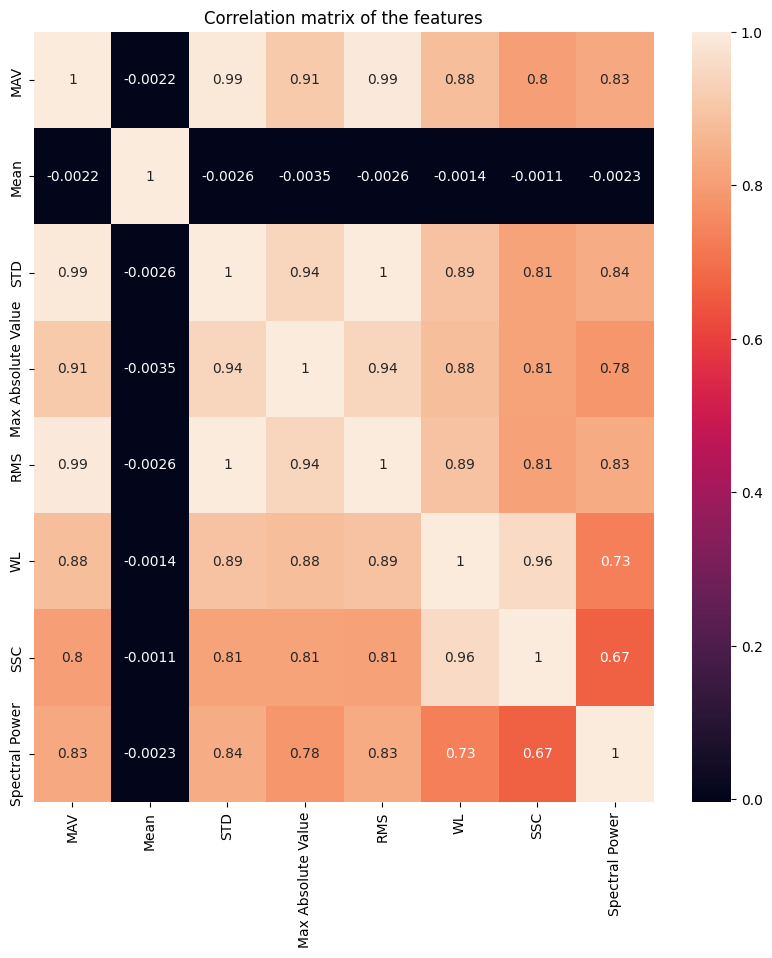

EMG train extracted features shape: (18339, 128), Fingler labels feature shape:(18339, 5)
EMG test extracted features shape: (4585, 128), Fingler labels feature shape:(4585, 5)


In [17]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

#Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features)
EMG_train_extracted_features = scaler.transform(EMG_train_extracted_features)
EMG_test_extracted_features = scaler.transform(EMG_test_extracted_features)

correlation_mean = []
for i in range(n_electrodes):
    correlation_per_electrode = EMG_train_extracted_features[: , i :: n_electrodes]
    correlation = np.corrcoef(correlation_per_electrode.T)
    correlation_mean.append(correlation)

correlation_mean = np.mean(correlation_mean, axis=0)

features_names = ["MAV", "Mean", "STD", "Max Absolute Value", "RMS", "WL", "SSC", "Spectral Power"]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_mean, annot=True, xticklabels=features_names, yticklabels=features_names, ax=ax)
plt.title("Correlation matrix of the features")
plt.show()

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

Overall, there is a significant correlation across the features, suggesting the need to prune the features to retain only the most informative ones. We decided to retain mean, standard deviation (std), slope sign changes (ssc), and spectral power.

In [18]:
def extract_features_useful(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMS_ssc = np.sum(np.abs(np.diff(np.diff(EMG_windows, axis=1), axis=1)), axis=1)
    EMG_spectral_power = np.apply_along_axis(total_power, axis=1, arr=EMG_windows)  

    Labels_mean = np.mean(Labels_windows,axis=1)
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMS_ssc, EMG_spectral_power), axis=1)
    return EMG_extracted_features, Labels_mean

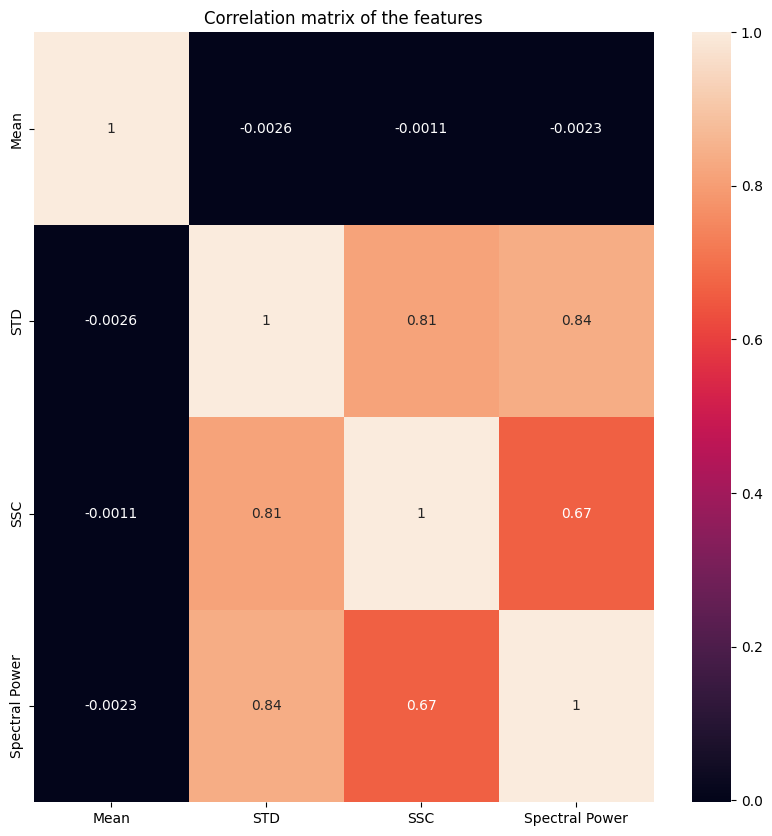

In [19]:
EMG_train_extracted_features, Labels_train_mean = extract_features_useful(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features_useful(EMG_test_windows,Labels_test_windows)

#Normalize features
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features)
EMG_train_extracted_features = scaler.transform(EMG_train_extracted_features)
EMG_test_extracted_features = scaler.transform(EMG_test_extracted_features)

correlation_mean = []
for i in range(n_electrodes):
    correlation_per_electrode = EMG_train_extracted_features[: , i :: n_electrodes]
    correlation = np.corrcoef(correlation_per_electrode.T)
    correlation_mean.append(correlation)

correlation_mean = np.mean(correlation_mean, axis=0)

features_names = ["Mean", "STD", "SSC", "Spectral Power"]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_mean, annot=True, xticklabels=features_names, yticklabels=features_names, ax=ax)
plt.title("Correlation matrix of the features")
plt.show()

### Regression 

For this part we train our Regressor. In our case the regressor is a Random Forest Regressor, we also added 5-folds cross validation and also a grid search to find the optimal parameters.

In [ ]:
# fit a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 20],
    'max_features': ['auto', 'sqrt'],
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(EMG_train_extracted_features, Labels_train_mean)
best_rf = grid_search.best_estimator_
print("Best Random Forest Regressor parameters: {}".format(grid_search.best_params_))

# save the model
import joblib
joblib.dump(best_rf, "best_rf_model.pkl")

# metrics
train_predictions = best_rf.predict(EMG_train_extracted_features)
test_predictions = best_rf.predict(EMG_test_extracted_features)

# plot the predictions
fig, axs = plt.subplots(n_joints, 1, figsize=(10, 10))
for i in range(n_joints):
    axs[i].plot(Labels_test_mean[:100, i], label="True")
    axs[i].plot(test_predictions[:100, i], label="Predicted")
    axs[i].set_title("Joint {}".format(i))
    axs[i].legend()
plt.tight_layout()
plt.show()



/Users/charlesboissier/miniforge3/envs/NSSP/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/charlesboissier/miniforge3/envs/NSSP/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/charlesboissier/miniforge3/envs/NSSP/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X

Looking at the graph we see that the actual and predicted data are indeed following the same trend. The best parameters selected for this model are ..., blablabla WAITING FOR CORRECT SPLITTING OF DATA

### Evaluation 

To evaluate the performance of our regressor, we used three metrics: MSE, R2, and adjusted R2.

- **MSE (Mean Squared Error)** provides insight when tuning parameters and selecting between models. It is primarily used to compare the performance of models on the same dataset. We utilized MSE during parameter tuning and to compare training and test samples to detect overfitting.

- **R2** measures the overall performance of the model by comparing it to a simple mean model.

- **Adjusted R2** evaluates the contribution of each feature to the model's performance. By comparing adjusted R2 to R2, we can assess whether the model is optimal and whether the included features are meaningful.

In [57]:
def r2_adj(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return r2_adj

n = EMG_test_extracted_features.shape[0]
p = EMG_test_extracted_features.shape[1]

train_r2_adj = r2_adj(Labels_train_mean, train_predictions, n, p)
test_r2_adj = r2_adj(Labels_test_mean, test_predictions, n, p)
train_mse = mean_squared_error(Labels_train_mean, train_predictions)
test_mse = mean_squared_error(Labels_test_mean, test_predictions)
train_r2 = r2_score(Labels_train_mean, train_predictions)
test_r2 = r2_score(Labels_test_mean, test_predictions)

print("Train MSE: {:.2f}".format(train_mse))
print("Test MSE: {:.2f}".format(test_mse))
print("Train R2: {:.2f}".format(train_r2))
print("Test R2: {:.2f}".format(test_r2))
print("Train R2 adjusted: {:.2f}".format(train_r2_adj))
print("Test R2 adjusted: {:.2f}".format(test_r2_adj))


Train MSE: 20.11
Test MSE: 134.78
Train R2: 0.98
Test R2: 0.85
Train R2 adjusted: 0.98
Test R2 adjusted: 0.85


The mean squared error on the testing set is slightly higher than on the training set, which could indicate a minor degree of overfitting. However, the difference is not substantial. The R2 value is high and matches the adjusted R2 value, indicating that the model performs well and is appropriately fitted.

### Joints 

Let's examine the differences in metrics across the joints.

In [61]:
joint_metrics = []
joints_name = [3,6,8,11,14]
for i in range(n_joints):
    joint_mse = mean_squared_error(Labels_test_mean[:, i], test_predictions[:, i])
    joint_metrics.append({"Joint": joints_name[i], "MSE": joint_mse})
joint_metrics_df = pd.DataFrame(joint_metrics)

print(joint_metrics_df)


   Joint         MSE
0      3   53.326093
1      6  119.861198
2      8  220.104094
3     11  144.532639
4     14  136.051617


Interestingly, there is less error in the joints associated with the thumb and index finger, while a noticeable peak is observed in the joint associated with the middle finger. However, the differences between them are not significant. These variations can be explained by the nature of the exercises. Specifically, there are more exercises that isolate the movements of the thumb and index finger, providing data that significantly enhances the prediction of their movements. In contrast, the movements of other joints are often coupled with the movement of adjacent joints, making it more challenging to predict them individually.